In [296]:
#here are all of the imports that could be needed 
#we're just going to transition over to a new environment 
import tensorflow as tf 
#keras is now integrated with tensorflow 
import numpy as np 
import matplotlib.pyplot as plt 
#import imageio
#import cv2
import pandas as pd 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers 
import time 
from IPython import display 
import os 


Found 2638 files belonging to 1 classes.
<MapDataset shapes: (None, 256, 256, 3), types: tf.float32>


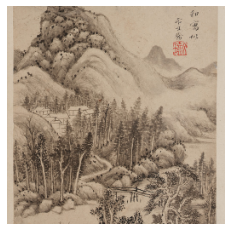

In [297]:
#import dataset 
#the below method doesn't work because the function belongs to tensorflow nightly builds or whatever 
#update it's available on tensorflow 2.9.0 or something but conda only has access to 2.8.1 
#dataset = tf.keras.preprocessing.image_dataset_from_directory('ImageDatasets')
#Have to figure out how to import from subdirectories as well because of the organizational structure of 
#ImageDatasets
#use flow_from_directory??? possibly

#ok this found it now I have to somehow get it into the model 
#might want to refine how the data is loaded 
#use 413 and see what happens? 
#replace 64 with 430 
#replace 128 with 826
#should check to see what all the functions do before I do anything with the dimensions 
dataset = tf.keras.preprocessing.image_dataset_from_directory('ImageDatasets', label_mode=None,  
                                                             batch_size=5)
#200 x 200 seems good now we have to replace everything with that value 
dataset = dataset.map(lambda x: x / 255.0)
#lmfao finally the data is loaded in 
#dataset = np.array(dataset, dtype=object)
#dataset = list(dataset)
#dataset = np.array(list(map(lambda x: float(x), dataset)))
#dataset = np.array(dataset, dtype=object)
#apparently this is a 0 dimension dataset? what? idk what i'm doing 
#dataset = np.expand_dims(dataset, axis=0)
#made it a np.array 
#dataset = dataset.reshape(dataset).astype('float32')
print(dataset)
#dataset = 
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

  


    

#dataset = dataset.
#normalization! 

#five to six batches should be good 

#how big should the batches be etc. 
#just have to change parameters in the flow_from_directory function I suppose 

#check the alice project to see how she processed her images etc. 

#dataset = ImageDataGenerator().flow_from_directory(directory='ImageDatasets', batch_size=5, target_size = (431, 431)



In [298]:
#discriminator code 
discriminator = tf.keras.Sequential(
    #maybe i optimized the heck out of this and maybe i've made a grave mistake 
    #no pooling involved; not recommended for DCGAN 
    #for some reason it is 
    [
        tf.keras.Input(shape=(256, 256, 3)),
        layers.Conv2D(8, kernel_size=3, strides=2, padding="same"),
        #layers.MaxPooling2D(pool_size=(2,2), strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.25),
        layers.BatchNormalization(momentum=0.8),
        #layers.MaxPooling2D(padding="same"),
        #pool
        layers.Conv2D(16, kernel_size=3, strides=2, padding="same"),
        #layers.MaxPooling2D(pool_size=(2,2), strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.25),
        layers.BatchNormalization(momentum=0.8),
        #layers.MaxPooling2D(padding="same"),
        #pool
        layers.Conv2D(32, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.25),
        layers.BatchNormalization(momentum=0.8),
        #layers.MaxPooling2D(padding="same"),
        
        layers.Conv2D(64, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.25),
        layers.BatchNormalization(momentum=0.8),
        #layers.MaxPooling2D(padding="same"),
        
        layers.Conv2D(256, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.25),
        layers.BatchNormalization(momentum=0.8),
    
        #layers.MaxPooling2D(padding="same"),
        
        
        
        
        
        
    
        
        #pool 
        #average and max pooling behave differently so this is why 
        #changed the code a bit 
        
        layers.Flatten(),
        #layers.Dense(256),
        layers.LeakyReLU(alpha=0.2),
        #layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()



Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_459 (Conv2D)         (None, 128, 128, 8)       224       
                                                                 
 leaky_re_lu_404 (LeakyReLU)  (None, 128, 128, 8)      0         
                                                                 
 dropout_205 (Dropout)       (None, 128, 128, 8)       0         
                                                                 
 batch_normalization_184 (Ba  (None, 128, 128, 8)      32        
 tchNormalization)                                               
                                                                 
 conv2d_460 (Conv2D)         (None, 64, 64, 16)        1168      
                                                                 
 leaky_re_lu_405 (LeakyReLU)  (None, 64, 64, 16)       0         
                                                     

In [299]:
latent_dim = 256
#change a few things here and there :/ 
#because so far this isn't working or something
#do i do a convolution or :/ 
#this might be bad lmfao 
#changing this around again :/ use upsampling instead of 2D Conv Transpose 
#This is causing checkerboard artifacts to pop up and I'm not very happy with that 
#methods to 
#add reflection 

generator = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(latent_dim,)),
        layers.Dense(8*8*256),
        layers.Reshape((8,8,256)),
        
        layers.UpSampling2D(),
        layers.Conv2D(256, kernel_size=3,padding="same"),
        layers.BatchNormalization(momentum=0.8),
        layers.LeakyReLU(alpha=0.2),
        
        layers.UpSampling2D(),
        layers.Conv2D(128, kernel_size=3, padding="same"),
        layers.BatchNormalization(momentum=0.8),
        layers.LeakyReLU(alpha=0.2),
        
        layers.UpSampling2D(),
        layers.Conv2D(64, kernel_size=3, padding="same"),
        layers.BatchNormalization(momentum=0.8),
        layers.LeakyReLU(alpha=0.2),
        
        layers.UpSampling2D(),
        layers.Conv2D(32, kernel_size=3, padding="same"),
        layers.BatchNormalization(momentum=0.8),
        layers.LeakyReLU(alpha=0.2),
        
        layers.UpSampling2D(),
        layers.Conv2D(16, kernel_size=3, padding="same"),
        layers.BatchNormalization(momentum=0.8),
        layers.LeakyReLU(alpha=0.2),
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        #ayers.Conv2D(256, kernel_size=2, strides=2, padding="same"),
        
        
       
        
        
        
        
        
        
        
        
        
        layers.Conv2D(3, kernel_size=3, padding="same", activation="tanh"),
    ],
    name="generator",
)
generator.summary()
'''layers.Conv2DTranspose(256, kernel_size=4, strides=(4,4), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        
        layers.Conv2DTranspose(512, kernel_size=4, strides=(4,4), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        '''


Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_151 (Dense)           (None, 16384)             4210688   
                                                                 
 reshape_80 (Reshape)        (None, 8, 8, 256)         0         
                                                                 
 up_sampling2d_134 (UpSampli  (None, 16, 16, 256)      0         
 ng2D)                                                           
                                                                 
 conv2d_464 (Conv2D)         (None, 16, 16, 256)       590080    
                                                                 
 batch_normalization_189 (Ba  (None, 16, 16, 256)      1024      
 tchNormalization)                                               
                                                                 
 leaky_re_lu_410 (LeakyReLU)  (None, 16, 16, 256)      0 

'layers.Conv2DTranspose(256, kernel_size=4, strides=(4,4), padding="same"),\n        layers.LeakyReLU(alpha=0.2),\n        \n        layers.Conv2DTranspose(512, kernel_size=4, strides=(4,4), padding="same"),\n        layers.LeakyReLU(alpha=0.2),\n        '

In [300]:
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }



In [301]:
class GANMonitor(tf.keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=256):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = tf.keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("generated_img_%03d_%d.png" % (epoch, i))


In [292]:
epochs = 100 # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=tf.keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)


Epoch 1/100
528/528 [==============================] - 164s 309ms/step - d_loss: 0.3897 - g_loss: 3.5311
Epoch 2/100
528/528 [==============================] - 164s 311ms/step - d_loss: 0.4746 - g_loss: 3.5473
Epoch 3/100
528/528 [==============================] - 166s 314ms/step - d_loss: 0.7028 - g_loss: 0.7620
Epoch 4/100
528/528 [==============================] - 165s 312ms/step - d_loss: 0.6774 - g_loss: 0.8374
Epoch 5/100
528/528 [==============================] - 165s 312ms/step - d_loss: 0.6909 - g_loss: 0.8682
Epoch 6/100
528/528 [==============================] - 166s 314ms/step - d_loss: 0.6792 - g_loss: 0.8302
Epoch 7/100
528/528 [==============================] - 166s 313ms/step - d_loss: 0.6773 - g_loss: 0.8317
Epoch 8/100
528/528 [==============================] - 168s 319ms/step - d_loss: 0.6285 - g_loss: 1.0111
Epoch 9/100
528/528 [==============================] - 167s 316ms/step - d_loss: 0.6969 - g_loss: 0.7469
Epoch 10/100
528/528 [==============================] -

528/528 [==============================] - 164s 310ms/step - d_loss: 0.6356 - g_loss: 0.9239
Epoch 79/100
528/528 [==============================] - 164s 310ms/step - d_loss: 0.6447 - g_loss: 0.9420
Epoch 80/100
528/528 [==============================] - 164s 310ms/step - d_loss: 0.6091 - g_loss: 1.0763
Epoch 81/100
528/528 [==============================] - 164s 310ms/step - d_loss: 0.6608 - g_loss: 0.9651
Epoch 82/100
528/528 [==============================] - 163s 309ms/step - d_loss: 0.6293 - g_loss: 0.9930
Epoch 83/100
528/528 [==============================] - 164s 311ms/step - d_loss: 0.6148 - g_loss: 1.1183
Epoch 84/100
528/528 [==============================] - 164s 310ms/step - d_loss: 0.6516 - g_loss: 0.9035
Epoch 85/100
528/528 [==============================] - 164s 311ms/step - d_loss: 0.6540 - g_loss: 0.9056
Epoch 86/100
528/528 [==============================] - 164s 310ms/step - d_loss: 0.5946 - g_loss: 1.1379
Epoch 87/100
528/528 [==============================] - 164

In [27]:
# N

In [29]:
#generating and saving images 



In [30]:
'''
def make_discriminator():
    model = tf.keras.Sequential(tf.keras.layers.Rescaling(1./255))
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model
discriminator = make_discriminator()

#generator code 
def make_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model
generator = make_generator()

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
#this is all standard, the things i have to change are probably how the data is loaded in itself
#and like the training loop 
#epochs
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

#checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

#otice the use of `tf.function`
# This annotation causes the function to be "compiled".
#fixed indentation--for some reason it was weird 
@tf.function
def train_step(images):
    
    noise = tf.random.normal([5, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        for image_batch in dataset:
            train_step(image_batch)
            
 
    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
        

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    display.clear_output(wait=True)
    #Generate after the final epoch 
    generate_and_save_images(generator,
                           epochs,
                           seed)
    
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow(predictions[i, :, :, 0]*127.5+127.5)
        plt.axis('off')
    plt.savefig('image_at_epoch{:04d}.png'.format(epoch))
    plt.show()
  #will have to change this
#one image? two images? 
#time to edit this :/ #training the guy 
train(dataset, EPOCHS)

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
'''

ValueError: in user code:

    File "<ipython-input-17-a2f055a28d97>", line 12, in train_step  *
        fake_output = discriminator(generated_images, training=True)
    File "/usr/local/anaconda3/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/anaconda3/lib/python3.7/site-packages/keras/engine/input_spec.py", line 248, in assert_input_compatibility
        f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Exception encountered when calling layer "sequential_2" (type Sequential).
    
    Input 0 of layer "conv2d_2" is incompatible with the layer: expected axis -1of input shape to have value 3, but received input with shape (5, 28, 28, 1)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(5, 28, 28, 1), dtype=float32)
      • training=True
      • mask=None


In [ ]:
#basic code to get started 
#annotate example code 
#another dead code graveyard, outdated, could use as reference 

'''from __future__ import print_function, division
#imports the handwriting dataset 
from keras.datasets import mnist
#functions for layers probably 
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
#more processing stuff (have to look up actual function)
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

class GAN():
    def __init__(self):
        #what is this doing 
        # i have to look up all of the keras functions involved and annotate 
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%d.png" % epoch)
        plt.close()


if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=30000, batch_size=32, sample_interval=200)'''


In [ ]:
#ded code graveyard 
'''#below is old code that doesn't work :/ 
	if r.status_code == 200: 
		if i.contains('png'):
			with open("*?.png", "wb") as f:
				r.raw.decode_content = True
				shutil.copyfileobj(r.raw, f)
		else:
			with open("*?.jpg", "wb") as f:
				r.raw.decode_content = True
				shutil.copyfileobj(r.raw, f)

			#		    shutil.copyfileobj(r.raw, f)
			

			
			
			
		                    #200 status code = OK'''
		'''